In [1]:

from datetime import datetime
import functools
import time # Added for PRNGKey seeding in rollout

import os

import jax
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt

import mujoco
from mujoco import mjx

from brax import envs
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State as BraxState # Alias Brax's State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo_lagrange import train as ppo_lagrange
from brax.training.agents.ppo_lagrange_v2 import train as ppo_lagrange_v2
from brax.training.agents.ppo_lagrange_v3 import train as ppo_lagrange_v3
from brax.io import html, mjcf, model as brax_model # Alias brax model
from brax.io import json as brax_json # Added for saving trajectories if needed
import wandb
from ml_collections import config_dict
import subprocess


In [2]:
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError('Cannot communicate with GPU. Make sure you have NVIDIA drivers installed.')

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
os.environ['MUJOCO_GL'] = 'egl'

try:
    print('Checking that the installation succeeded:')
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the error message above '
        'for more information.')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# Check for GPU availability
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError('Cannot communicate with GPU. Make sure you have NVIDIA drivers installed.')

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
os.environ['MUJOCO_GL'] = 'egl'

try:
    print('Checking that the installation succeeded:')
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the error message above '
        'for more information.')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Sat Aug 30 02:27:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   62C    P0             89W /  170W |    1687MiB /  12288MiB |     44%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
def default_config() -> config_dict.ConfigDict:
  """Returns the default config for PointHazardGoal environment."""
  config = config_dict.create(
      # New safety-gymnasium reward parameters
      reward_distance=3,  # Match successful PPO config
      reward_goal=10.0,      # Match successful PPO config
      goal_size=0.7,        # Distance threshold for achieving the goal
      reward_orientation=False, # Optional: Reward for maintaining upright orientation
      reward_orientation_scale=0.002, # Scale for orientation reward
      reward_orientation_body='agent', # Body to check orientation (unused if reward_orientation=False)
      ctrl_cost_weight=0.001, # Match successful PPO config
      hazard_size=0.7,       # Distance threshold for hazard cost
      # Other parameters (kept or adjusted)
      terminate_when_unhealthy=True, # Keep termination based on health
      healthy_z_range=(0.05, 0.3),    # Keep health definition
      reset_noise_scale=0.005,
      exclude_current_positions_from_observation=True,
      max_velocity=5.0,  # Keep velocity limit for calculation stability
      debug=False,
  )
  return config

In [4]:
env_name = 'point_resetting_goal_random_hazard_lidar_sensor_obs'
# metrics_list = [] # This can be removed if wandb is the primary logger for training progress
# Instantiate the training environment
train_environment = envs.get_environment(env_name)
# Instantiate a separate environment for evaluation/rollout
eval_env = envs.get_environment(env_name) # Using the same type for now

print(f"Training environment '{env_name}' instantiated.")
print(f"Evaluation environment '{env_name}' instantiated.")


Body 0 name: world, mocapid: [-1]
Body 1 name: agent, mocapid: [-1]
Body 2 name: goal, mocapid: [0]
Goal body found with mocapid: [0]
Body 3 name: hazard1, mocapid: [1]
Hazard body found with mocapid: [1]
Body 4 name: hazard2, mocapid: [2]
Hazard body found with mocapid: [2]
Body 5 name: hazard3, mocapid: [3]
Hazard body found with mocapid: [3]
Model has 7 sensors. Searching for required sensors...
  Found sensor: accelerometer, ID: 0, Address: 0, Dim: 3
  Found sensor: velocimeter, ID: 1, Address: 3, Dim: 3
  Found sensor: gyro, ID: 2, Address: 6, Dim: 3
  Found sensor: magnetometer, ID: 3, Address: 9, Dim: 3
Body 0 name: world, mocapid: [-1]
Body 1 name: agent, mocapid: [-1]
Body 2 name: goal, mocapid: [0]
Goal body found with mocapid: [0]
Body 3 name: hazard1, mocapid: [1]
Hazard body found with mocapid: [1]
Body 4 name: hazard2, mocapid: [2]
Hazard body found with mocapid: [2]
Body 5 name: hazard3, mocapid: [3]
Hazard body found with mocapid: [3]
Model has 7 sensors. Searching for 

/home/mrdbstn/school/safe-brax/safe-brax/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [5]:
# Import necessary modules for the wrapper
from brax.envs.base import Wrapper

# Define a custom wrapper to handle cost field properly
class CostExtraWrapper(Wrapper):
    """Wrapper that moves cost from info to extras for PPO Lagrange."""
    
    def step(self, state: BraxState, action: jax.Array) -> BraxState:
        next_state = self.env.step(state, action)
        
        # PPO Lagrange expects cost in state.info during collection,
        # and the training wrapper will move it to extras automatically
        # Just ensure cost is in info
        if 'cost' not in next_state.info:
            # If cost is in metrics, copy it to info
            if 'cost' in next_state.metrics:
                next_state.info['cost'] = next_state.metrics['cost']
            else:
                # Default to 0 if no cost found
                next_state.info['cost'] = jnp.zeros_like(next_state.reward)
        
        return next_state
    
    def reset(self, rng: jax.Array) -> BraxState:
        state = self.env.reset(rng)
        # Ensure cost is initialized in info
        if 'cost' not in state.info:
            state.info['cost'] = jnp.zeros_like(state.reward)
        return state

# Custom wrap function that includes the cost wrapper
def wrap_env_with_cost(env: envs.Env) -> envs.Env:
    """Wrap environment with cost handling for PPO Lagrange."""
    return CostExtraWrapper(env)


In [6]:
def custom_progress_fn(num_steps, metrics, metrics_list=None, use_wandb=False):
    """
    Progress function to print metrics and log to Weights & Biases.
    `metrics` dict can come from Brax's EpisodeMetricsLogger (keys like 'episode/reward')
    or from Evaluator (keys like 'eval/episode_reward').
    """
    print(f"Step {num_steps}:")
    wandb_log_data = {}
    for key, value in metrics.items():
        log_value = value.item() if hasattr(value, 'item') else value 
        # Print lambda and cost-related metrics for debugging
        if "lambda" in key or "cost" in key or "constraint" in key:
            print(f"  {key}: {log_value}")
        
        if not (key.startswith("episode/") or key.startswith("eval/") or key.startswith("training/")):
             wandb_log_data[f"training_batch/{key}"] = log_value 
        else:
             wandb_log_data[key] = log_value

    if use_wandb and wandb.run is not None and wandb_log_data:
        wandb.log(wandb_log_data, step=int(num_steps))

    if metrics_list is not None: 
        metrics_data_local = {'step': num_steps}
        metrics_data_local.update(metrics) 
        metrics_list.append(metrics_data_local)

In [ ]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items(): 
            setattr(self, key, value)

# Training Arguments (Args class definition as before)
args = Args(
    num_timesteps=30_000_000,
    num_evals=50, # This controls how many times the separate eval_env is run
    reward_scaling=0.1,
    episode_length=2000,
    normalize_observations=True,
    action_repeat=1, 
    unroll_length=8,
    num_minibatches=32,
    num_updates_per_batch=6,
    discounting=0.99,
    learning_rate=5e-4,
    entropy_cost=5e-3,
    num_envs=2048,
    batch_size=1024,
    max_devices_per_host=None,
    seed=0,  # Match successful PPO config
    safety_bound=0.2,
    lagrangian_coef_rate=0.01,
    initial_lambda_lagr=0.0,
)

# This ensures both training and evaluation use the same cost computation
print(f"Applied PPOLagrangeCostWrapper to both training and evaluation environments")
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# +++ Initialize Weights & Biases +++ (Same as before)
config_dict_for_wandb = vars(args)
env = envs.get_environment(env_name)
current_env_config_for_wandb = default_config().to_dict()
config_dict_for_wandb.update({
    "environment_name": env_name,
    "reward_distance": current_env_config_for_wandb.get("reward_distance"),
    "reward_goal": current_env_config_for_wandb.get("reward_goal"),
    "goal_size": current_env_config_for_wandb.get("goal_size"),
    "ctrl_cost_weight": current_env_config_for_wandb.get("ctrl_cost_weight"),
    "reward_orientation": current_env_config_for_wandb.get("reward_orientation"),
    "reward_orientation_scale": current_env_config_for_wandb.get("reward_orientation_scale"),
})
run_name = f"{env_name}_ppo_lag_v3_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
run = wandb.init(
    project="safe_brax",
    name=run_name,
    config=config_dict_for_wandb,
)
# ++++++++++++++++++++++++++++++++

# Bound progress function (This now becomes more important for training metrics)
metrics_list = []
# Ensure custom_progress_fn is ready to handle metrics dictionary and log to wandb
# (Definition of custom_progress_fn shown after this cell block)
bound_progress_fn = functools.partial(custom_progress_fn, metrics_list=metrics_list, use_wandb=True)

# Setup the PPO training function
train_fn = functools.partial(
    ppo_lagrange_v3,
    num_timesteps=args.num_timesteps,
    num_evals=args.num_evals, # For separate evaluations using eval_env
    reward_scaling=args.reward_scaling,
    episode_length=args.episode_length,
    normalize_observations=args.normalize_observations,
    action_repeat=args.action_repeat,
    unroll_length=args.unroll_length,
    num_minibatches=args.num_minibatches,
    num_updates_per_batch=args.num_updates_per_batch,
    learning_rate=args.learning_rate,
    entropy_cost=args.entropy_cost,
    discounting=args.discounting,
    num_envs=args.num_envs,
    batch_size=args.batch_size,
    max_devices_per_host=args.max_devices_per_host,
    seed=args.seed,
    # +++ Brax's new training metrics logging +++
    log_training_metrics=True, # Enable Brax's internal episode metrics logging
    training_metrics_steps=100000, # Example: log ~5 times per "epoch" of data collection
    # Or set to a fixed number like 100000, or None to use default
    # +++++++++++++++++++++++++++++++++++++++++++++
    safety_bound=args.safety_bound,
    lagrangian_coef_rate=args.lagrangian_coef_rate,
    initial_lambda_lagr=args.initial_lambda_lagr,
)
print("Training arguments and PPO train_fn configured. Weights & Biases run initialized.")

Applied PPOLagrangeCostWrapper to both training and evaluation environments
Body 0 name: world, mocapid: [-1]
Body 1 name: agent, mocapid: [-1]
Body 2 name: goal, mocapid: [0]
Goal body found with mocapid: [0]
Body 3 name: hazard1, mocapid: [1]
Hazard body found with mocapid: [1]
Body 4 name: hazard2, mocapid: [2]
Hazard body found with mocapid: [2]
Body 5 name: hazard3, mocapid: [3]
Hazard body found with mocapid: [3]
Model has 7 sensors. Searching for required sensors...
  Found sensor: accelerometer, ID: 0, Address: 0, Dim: 3
  Found sensor: velocimeter, ID: 1, Address: 3, Dim: 3
  Found sensor: gyro, ID: 2, Address: 6, Dim: 3
  Found sensor: magnetometer, ID: 3, Address: 9, Dim: 3


wandb: Currently logged in as: m-boustani (m-boustani-eindhoven-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training arguments and PPO train_fn configured. Weights & Biases run initialized.


wandb: WARNING Tried to log to step 30000000 that is less than the current step 38535168. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


In [8]:
print(f"Starting PPO-Lagrange training for {env_name}...")
make_inference_fn, params, final_eval_metrics = train_fn( # Renamed for clarity
    environment=train_environment,
    eval_env=eval_env, # Pass the separate eval_environment
    progress_fn=bound_progress_fn
)
print("Training finished.")
print(f"Final evaluation metrics: {final_eval_metrics}")

# +++ Log final evaluation metrics to W&B +++
if wandb.run is not None and final_eval_metrics:
    # These metrics should already be prefixed with 'eval/' by evaluator.run_evaluation
    # if not, you might need to add it.
    # Let's assume they are correctly prefixed or are self-descriptive.
    final_log_data = {}
    for key, value in final_eval_metrics.items():
        log_value = value.item() if hasattr(value, 'item') else value
        # If keys from final_eval_metrics are not prefixed with 'eval/', add it
        # Example: if key is 'episode_reward', log as 'final_eval/episode_reward'
        # if not key.startswith("eval/"):
        #     final_log_data[f"final_evaluation/{key}"] = log_value
        # else:
        final_log_data[key] = log_value # Assuming keys are like 'eval/episode_reward'

    wandb.log(final_log_data, step=int(args.num_timesteps)) # Log at the final step
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting PPO-Lagrange training for point_resetting_goal_random_hazard_lidar_sensor_obs...
Reset method - Goal Position: Traced<ShapedArray(float32[3])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[2048,3])>with<BatchTrace> with
    val = Traced<ShapedArray(float32[1,2048,3])>with<DynamicJaxprTrace>
    batch_dim = 0
  batch_dim = 0


/home/mrdbstn/school/safe-brax/safe-brax/env/lib/python3.10/site-packages/jax/_src/interpreters/xla.py:112: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Reset method - Goal Position: Traced<ShapedArray(float32[3])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[128,3])>with<DynamicJaxprTrace>
  batch_dim = 0
Step 0:
  eval/episode_cost: 275.8359375
  eval/episode_ctrl_cost: 0.9900192022323608
  eval/episode_cost_std: 272.9474792480469
  eval/episode_ctrl_cost_std: 0.01614878699183464
Step 262144:
Step 524288:
Step 786432:
Reset method - Goal Position: Traced<ShapedArray(float32[3])>with<BatchTrace> with
  val = Traced<ShapedArray(float32[128,3])>with<DynamicJaxprTrace>
  batch_dim = 0
Step 786432:
  training/cost_v_loss: 27.921396255493164
  training/cost_violation: 0.01706390082836151
  training/lambda_lagr: 0.0002383753308095038
  training/mean_cost: 0.21706390380859375
  eval/episode_cost: 392.5078125
  eval/episode_ctrl_cost: 1.2161998748779297
  eval/episode_cost_std: 426.0267639160156
  eval/episode_ctrl_cost_std: 0.0349203385412693
Step 1048576:
Step 1310720:
Step 1572864:
Step 1572864:
  training/cost_v_loss: 1.6110693

In [9]:
# import csv
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# metrics_filename = f"metrics/training_metrics_notebook_{env_name}_{timestamp}.csv"
# os.makedirs('metrics', exist_ok=True)
# with open(metrics_filename, 'w', newline='') as f:
#     writer = csv.writer(f)
#     # ... (write headers and data from metrics_list as in your save_brax_metrics) ...
# print(f"Metrics saved to {metrics_filename}")

In [10]:
# Save the trained model (params)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'models/{env_name.lower()}_lag_notebook_{timestamp}'
os.makedirs('models', exist_ok=True)
brax_model.save_params(model_path, params)
print(f"Trained model parameters saved to: {model_path}")

Trained model parameters saved to: models/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_notebook_20250830_024831


In [11]:
# Instantiate a separate environment for evaluation/rollout
eval_env_name = env_name # Or the same env_name
eval_environment = envs.get_environment(eval_env_name)

# jit reset and step for the eval environment
jit_eval_reset = jax.jit(eval_environment.reset)
jit_eval_step = jax.jit(eval_environment.step)

# Create the actual inference function using the factory and loaded params
# `params` here is the 3-tuple: (normalizer_params, policy_network_weights, value_network_weights)
# `make_inference_fn` knows how to use these.
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

print(f"Inference function for rollout created for {eval_env_name}.")

Body 0 name: world, mocapid: [-1]
Body 1 name: agent, mocapid: [-1]
Body 2 name: goal, mocapid: [0]
Goal body found with mocapid: [0]
Body 3 name: hazard1, mocapid: [1]
Hazard body found with mocapid: [1]
Body 4 name: hazard2, mocapid: [2]
Hazard body found with mocapid: [2]
Body 5 name: hazard3, mocapid: [3]
Hazard body found with mocapid: [3]
Model has 7 sensors. Searching for required sensors...
  Found sensor: accelerometer, ID: 0, Address: 0, Dim: 3
  Found sensor: velocimeter, ID: 1, Address: 3, Dim: 3
  Found sensor: gyro, ID: 2, Address: 6, Dim: 3
  Found sensor: magnetometer, ID: 3, Address: 9, Dim: 3
Inference function for rollout created for point_resetting_goal_random_hazard_lidar_sensor_obs.


/home/mrdbstn/school/safe-brax/safe-brax/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [12]:
num_rollout_steps = 5000
rollout_frames = []

# Data collection for plotting (expanded)
rollout_metrics_data = {
    'distance_to_goal': [],
    'last_dist_goal': [], # New
    'reward': [],
    'dist_reward': [],       # New
    'goal_reward': [],       # New
    'orientation_reward': [],# New
    'ctrl_cost': [],         # New
    'x_position': [],
    'y_position': [],
    'agent_pos_x': [],       # New
    'agent_pos_y': [],       # New
    'goal_pos_x': [],        # New
    'goal_pos_y': [],        # New
    'x_velocity': [],
    'y_velocity': [],
    'goals_reached_count': [],
    'cost': []
}

actions = []

rng_rollout = jax.random.PRNGKey(int(time.time()))
eval_state = jit_eval_reset(rng_rollout)

print(f"Starting rollout for {num_rollout_steps} steps...")
for i in range(num_rollout_steps):
    act_rng, rng_rollout = jax.random.split(rng_rollout)
    action, _ = jit_inference_fn(eval_state.obs, act_rng)
    actions.append(action)
    
    # Store agent_pos and goal_pos *before* the step, if they are needed for "last_goal_pos" type logic
    # For current step's agent_pos and goal_pos, they are in eval_state.info *after* the step.

    eval_state = jit_eval_step(eval_state, action)
    rollout_frames.append(eval_state.pipeline_state)

    # Collect metrics from eval_state.metrics
    rollout_metrics_data['distance_to_goal'].append(eval_state.metrics.get('distance_to_goal', np.nan))
    rollout_metrics_data['reward'].append(eval_state.metrics.get('reward', np.nan))
    rollout_metrics_data['cost'].append(eval_state.metrics.get('cost', np.nan))
    rollout_metrics_data['dist_reward'].append(eval_state.metrics.get('dist_reward', np.nan))
    rollout_metrics_data['goal_reward'].append(eval_state.metrics.get('goal_reward', np.nan))
    rollout_metrics_data['orientation_reward'].append(eval_state.metrics.get('orientation_reward', np.nan))
    rollout_metrics_data['ctrl_cost'].append(eval_state.metrics.get('ctrl_cost'))
    rollout_metrics_data['x_position'].append(eval_state.metrics.get('x_position', np.nan))
    rollout_metrics_data['y_position'].append(eval_state.metrics.get('y_position', np.nan))
    rollout_metrics_data['x_velocity'].append(eval_state.metrics.get('x_velocity', np.nan))
    rollout_metrics_data['y_velocity'].append(eval_state.metrics.get('y_velocity', np.nan))
    rollout_metrics_data['goals_reached_count'].append(eval_state.metrics.get('goals_reached_count', np.nan))

    # Collect metrics from eval_state.info (these are from the *current* state after the step)
    rollout_metrics_data['last_dist_goal'].append(eval_state.info.get('last_dist_goal', np.nan))
    current_agent_pos = eval_state.info.get('agent_pos', np.array([np.nan, np.nan, np.nan]))
    current_goal_pos = eval_state.info.get('goal_pos', np.array([np.nan, np.nan, np.nan]))
    rollout_metrics_data['agent_pos_x'].append(current_agent_pos[0])
    rollout_metrics_data['agent_pos_y'].append(current_agent_pos[1])
    rollout_metrics_data['goal_pos_x'].append(current_goal_pos[0])
    rollout_metrics_data['goal_pos_y'].append(current_goal_pos[1])
    
    if i % 100 == 0 or i == num_rollout_steps - 1:
        print(f"Rollout step {i+1}/{num_rollout_steps} completed. Goals reached: {eval_state.metrics.get('goals_reached_count', 0)}")

    if eval_state.done:
        print(f"Rollout terminated early at step {i+1} due to done signal.")
        remaining_steps = num_rollout_steps - (i + 1)
        for key_metric in rollout_metrics_data.keys():
            rollout_metrics_data[key_metric].extend([np.nan] * remaining_steps)
        break
print("Rollout finished.")

# Save trajectory as JSON (optional)
trajectory_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs('trajectories', exist_ok=True)
rollout_trajectory_path = f'trajectories/{eval_env_name}_lag_rollout_notebook.json'
brax_json.save(rollout_trajectory_path, eval_environment.sys, rollout_frames)
print(f"Rollout trajectory saved to {rollout_trajectory_path}")

# Render video (optional)
# video_html = HTML(html.render(eval_environment.sys, rollout_frames))
# video_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# os.makedirs('videos', exist_ok=True)
# media.write_video(f'videos/{eval_env_name}_rollout_notebook_{video_timestamp}.mp4', 
#                   eval_environment.render(rollout_frames, camera='side'),
#                   fps=1.0 / eval_environment.dt)
# print(f"Rollout video saved.")
# video_html

# save metrics to wandb

Reset method - Goal Position: Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace>
Starting rollout for 5000 steps...
Rollout step 1/5000 completed. Goals reached: 0.0
Rollout step 101/5000 completed. Goals reached: 0.0
Rollout step 201/5000 completed. Goals reached: 1.0
Rollout step 301/5000 completed. Goals reached: 1.0
Rollout step 401/5000 completed. Goals reached: 1.0
Rollout step 501/5000 completed. Goals reached: 2.0
Rollout step 601/5000 completed. Goals reached: 2.0
Rollout step 701/5000 completed. Goals reached: 3.0
Rollout step 801/5000 completed. Goals reached: 3.0
Rollout step 901/5000 completed. Goals reached: 3.0
Rollout step 1001/5000 completed. Goals reached: 4.0
Rollout step 1101/5000 completed. Goals reached: 4.0
Rollout step 1201/5000 completed. Goals reached: 4.0
Rollout step 1301/5000 completed. Goals reached: 4.0
Rollout step 1401/5000 completed. Goals reached: 4.0
Rollout step 1501/5000 completed. Goals reached: 4.0
Rollout step 1601/5000 completed. Goals reac

In [13]:
def analyze_rollout_bug(rollout_metrics_data):
    """Analyze the rollout data to find the distance reward bug."""
    print("=== Analyzing Rollout Distance Reward Bug ===")
    
    # Extract data
    distance_to_goal = np.array(rollout_metrics_data['distance_to_goal'])
    last_dist_goal = np.array(rollout_metrics_data['last_dist_goal'])
    dist_reward = np.array(rollout_metrics_data['dist_reward'])
    goal_reward = np.array(rollout_metrics_data['goal_reward'])
    
    # Find goal achievement steps
    goal_steps = np.where(goal_reward > 0)[0]
    print(f"Goal achieved at steps: {goal_steps}")
    
    # Focus on the problem area - after first goal achievement
    if len(goal_steps) > 0:
        problem_start = goal_steps[0]
        
        print(f"\nAnalyzing steps around goal reset (step {problem_start}):")
        
        for i in range(max(0, problem_start-2), min(problem_start + 10, len(distance_to_goal))):
            # Manual calculation of expected distance reward
            if i > 0:
                expected_dist_reward = last_dist_goal[i] - distance_to_goal[i]
            else:
                expected_dist_reward = 0.0
                
            actual_dist_reward = dist_reward[i]
            
            marker = " <-- GOAL!" if i == problem_start else ""
            print(f"  Step {i}: dist_to_goal={distance_to_goal[i]:.3f}, "
                  f"last_dist_goal={last_dist_goal[i]:.3f}, "
                  f"expected_reward={expected_dist_reward:.4f}, "
                  f"actual_reward={actual_dist_reward:.4f}{marker}")
    
    # Check if last_dist_goal equals distance_to_goal
    diff = np.abs(last_dist_goal - distance_to_goal)
    max_diff = np.max(diff)
    steps_with_diff = np.sum(diff > 1e-4)
    
    print(f"\nComparison of last_dist_goal vs distance_to_goal:")
    print(f"  Max difference: {max_diff:.6f}")
    print(f"  Steps with significant difference (>1e-4): {steps_with_diff}")
    print(f"  Are they essentially identical? {max_diff < 1e-3}")
    
    # If they're identical, that's the bug!
    if max_diff < 1e-3:
        print(f"\n🚨 BUG FOUND: last_dist_goal ≈ distance_to_goal")
        print(f"   This makes dist_reward = (last_dist_goal - distance_to_goal) ≈ 0")
        print(f"   The agent can move freely without distance penalties!")
    
    # Check the actual values during the major movement
    if len(goal_steps) > 0:
        start_step = goal_steps[0] + 1
        end_step = min(start_step + 50, len(distance_to_goal))
        
        print(f"\nDuring major movement (steps {start_step}-{end_step}):")
        movement_distances = distance_to_goal[end_step-1] - distance_to_goal[start_step]
        total_dist_rewards = np.sum(dist_reward[start_step:end_step])
        
        print(f"  Distance change: {distance_to_goal[start_step]:.2f} → {distance_to_goal[end_step-1]:.2f} "
              f"(Δ = {movement_distances:.2f})")
        print(f"  Total distance rewards: {total_dist_rewards:.4f}")
        print(f"  Expected total if working: ≈ {-movement_distances:.2f}")
        
        if abs(total_dist_rewards) < 0.1 and abs(movement_distances) > 10:
            print(f"  🚨 CONFIRMED: Large movement ({movement_distances:.1f}) with tiny rewards ({total_dist_rewards:.4f})")

# Run the analysis
analyze_rollout_bug(rollout_metrics_data)

=== Analyzing Rollout Distance Reward Bug ===
Goal achieved at steps: [190 417 655 923]

Analyzing steps around goal reset (step 190):
  Step 188: dist_to_goal=0.711, last_dist_goal=0.711, expected_reward=0.0000, actual_reward=0.0290
  Step 189: dist_to_goal=0.701, last_dist_goal=0.701, expected_reward=0.0000, actual_reward=0.0290
  Step 190: dist_to_goal=0.691, last_dist_goal=1.200, expected_reward=0.5089, actual_reward=0.0291 <-- GOAL!
  Step 191: dist_to_goal=1.202, last_dist_goal=1.202, expected_reward=0.0000, actual_reward=-0.0067
  Step 192: dist_to_goal=1.204, last_dist_goal=1.204, expected_reward=0.0000, actual_reward=-0.0066
  Step 193: dist_to_goal=1.206, last_dist_goal=1.206, expected_reward=0.0000, actual_reward=-0.0060
  Step 194: dist_to_goal=1.209, last_dist_goal=1.209, expected_reward=0.0000, actual_reward=-0.0062
  Step 195: dist_to_goal=1.211, last_dist_goal=1.211, expected_reward=0.0000, actual_reward=-0.0064
  Step 196: dist_to_goal=1.213, last_dist_goal=1.213, expe

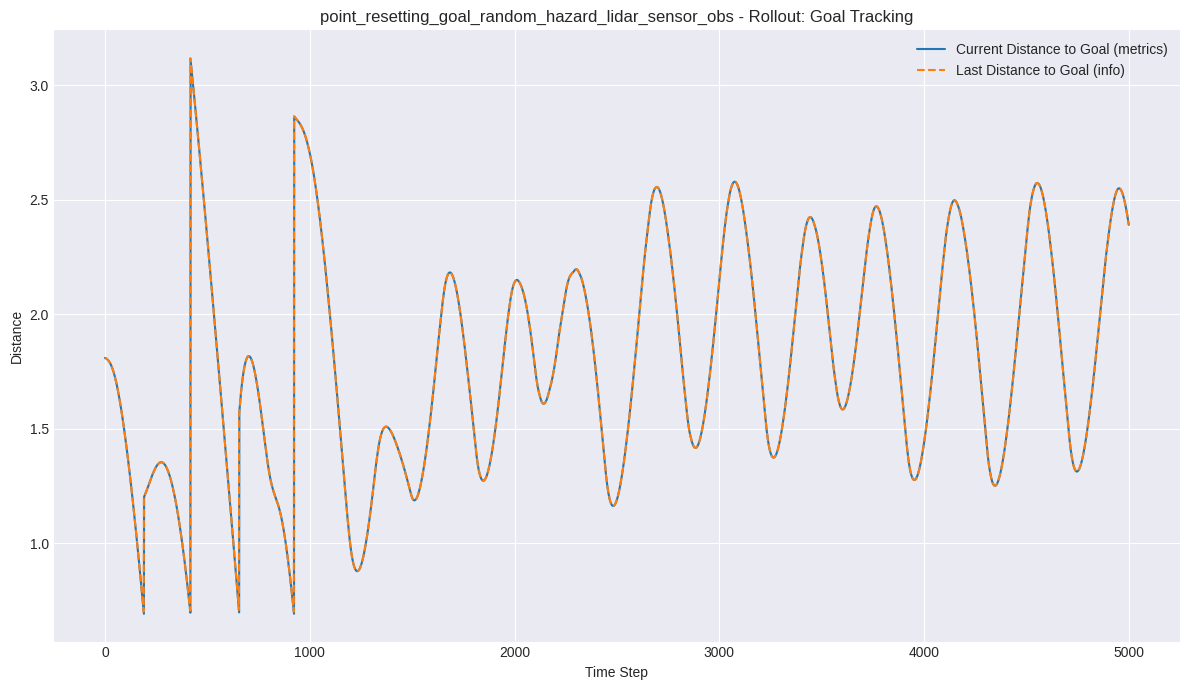

Goal tracking plot saved to: plots/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_rollout_notebook_20250830_025036_goal_distances.png


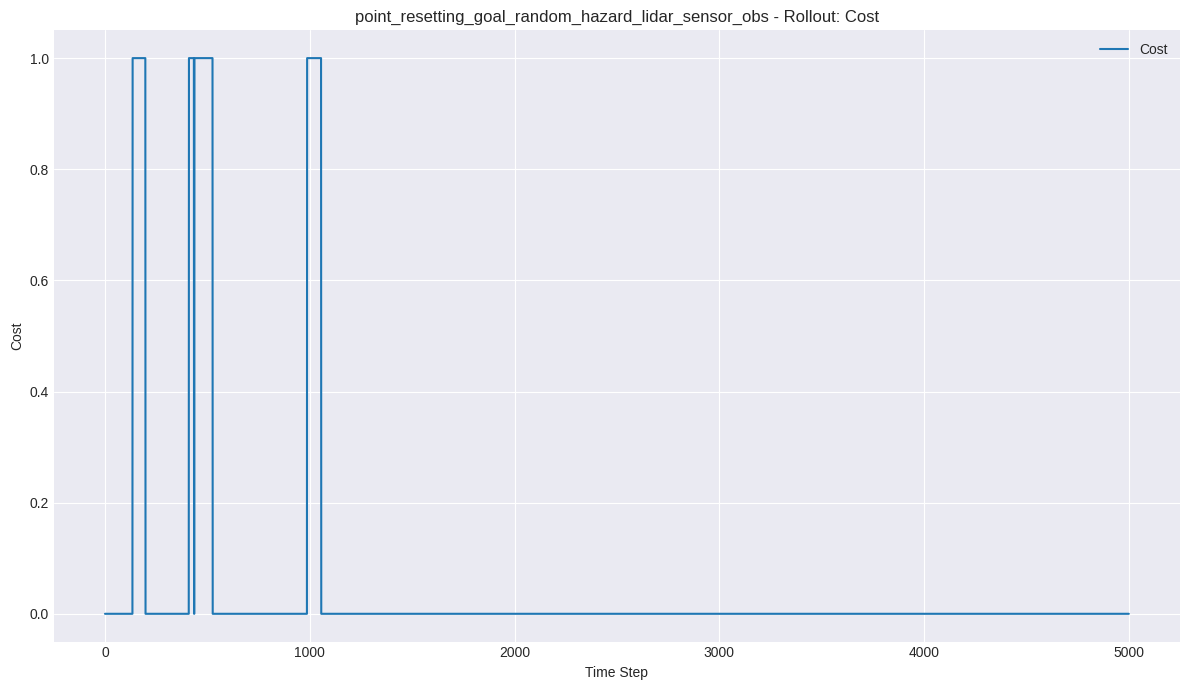

Cost plot saved to: plots/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_rollout_notebook_20250830_025036_cost.png


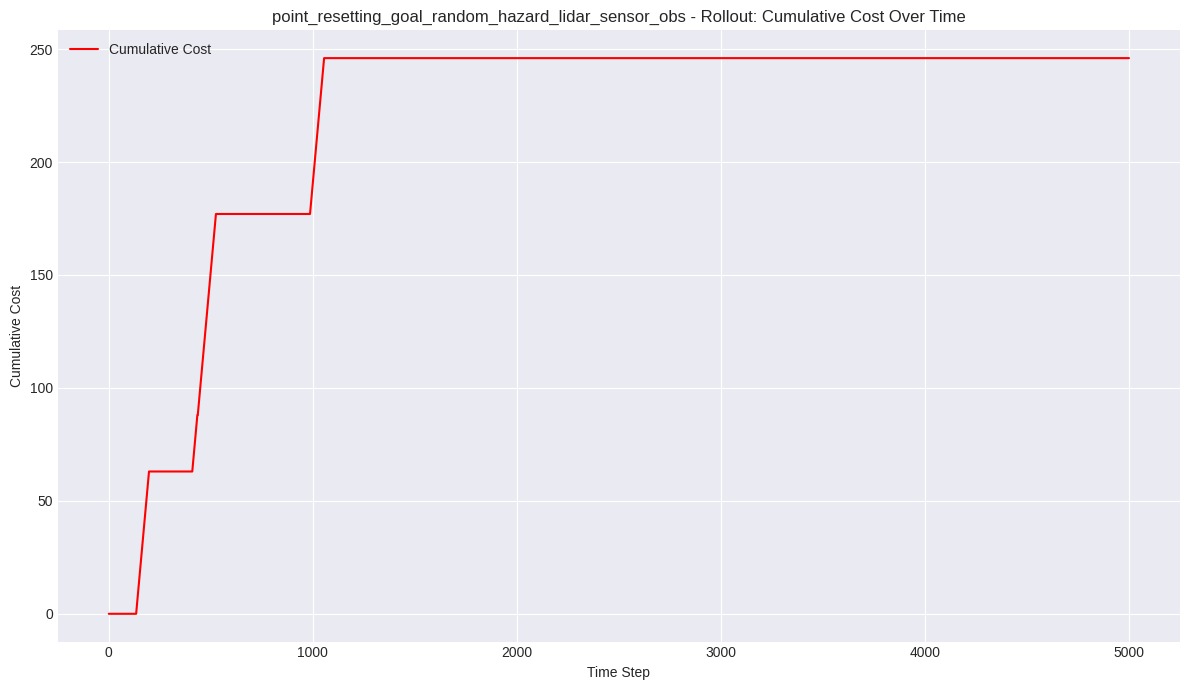

Cumulative cost plot saved to: plots/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_rollout_notebook_20250830_025036_cumulative_cost.png


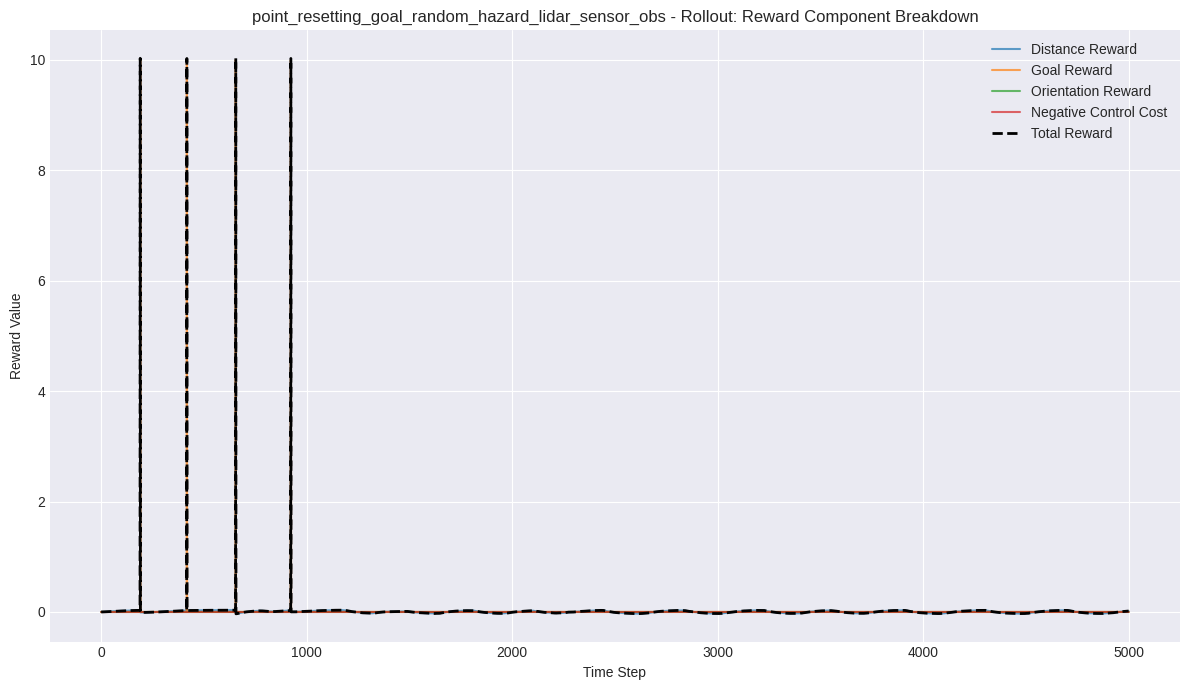

Reward breakdown plot saved to: plots/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_rollout_notebook_20250830_025036_reward_breakdown.png


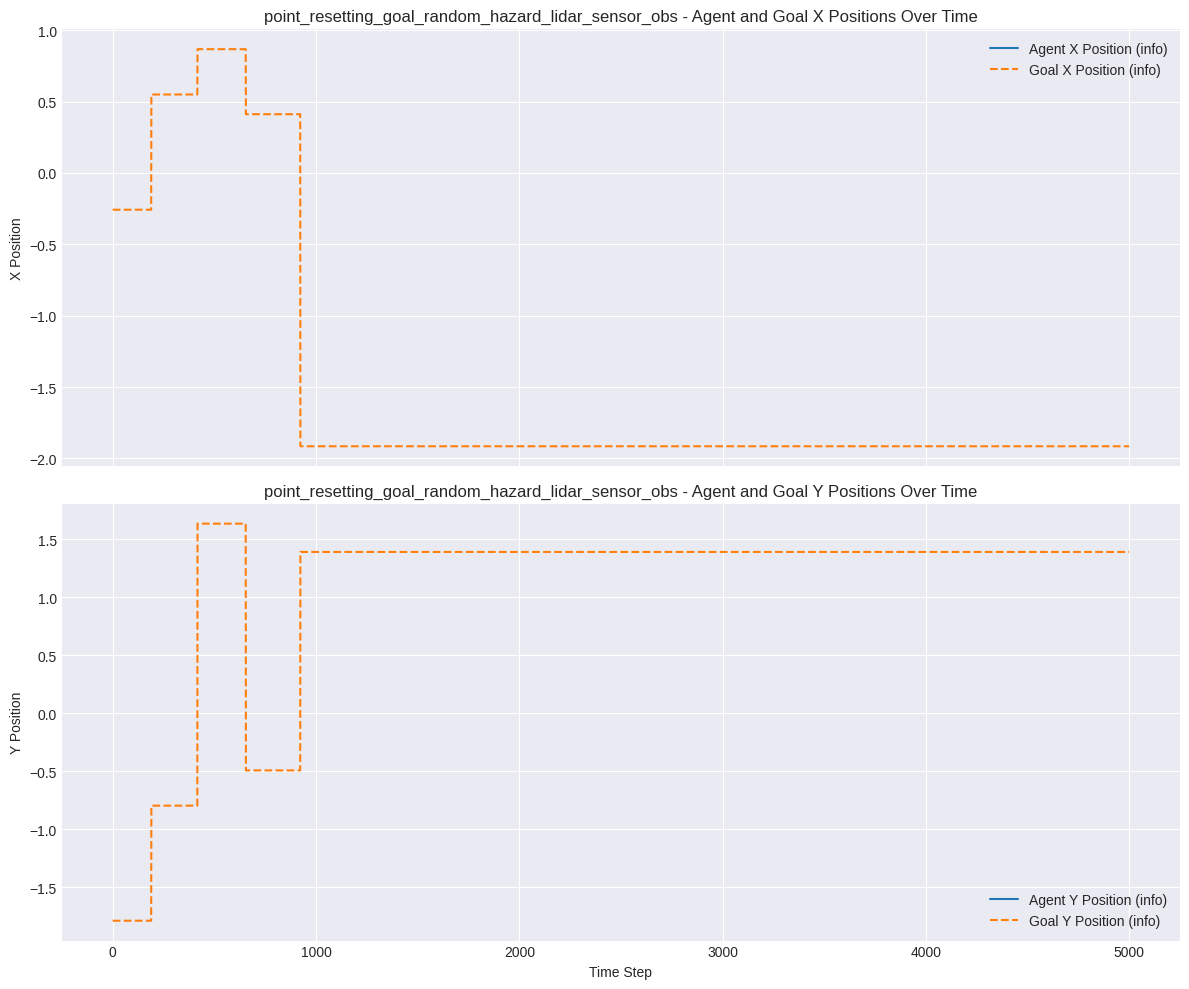

Agent and Goal positions plot saved to: plots/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_rollout_notebook_20250830_025036_agent_goal_positions.png


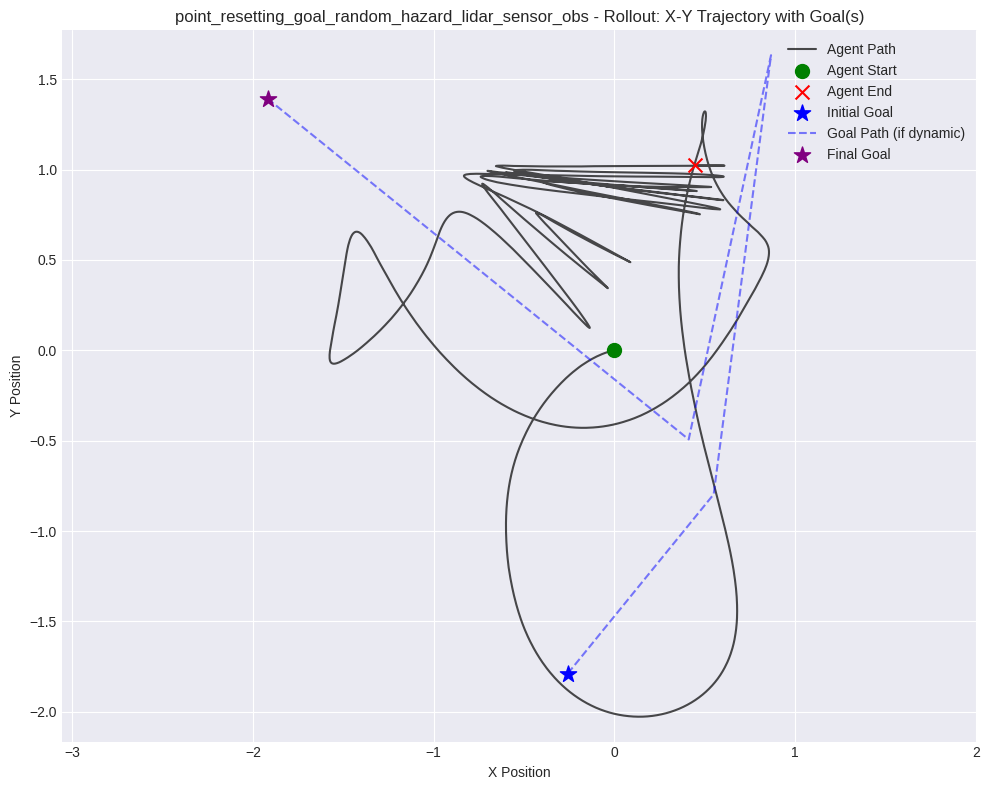

X-Y trajectory plot with goals saved to: plots/point_resetting_goal_random_hazard_lidar_sensor_obs_lag_rollout_notebook_20250830_025036_xy_trajectory_with_goals.png


In [14]:

plot_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)
plot_path_base = f'{plot_dir}/{eval_env_name}_lag_rollout_notebook_{plot_timestamp}'
num_actual_rollout_steps = len(rollout_metrics_data['distance_to_goal']) # Use a consistent metric for length
time_steps_rollout = np.arange(num_actual_rollout_steps)

plt.style.use('seaborn-v0_8-darkgrid')

# Plot 1: Distance and Last Distance to Goal
plt.figure(figsize=(12, 7))
plt.plot(time_steps_rollout, rollout_metrics_data['distance_to_goal'], label='Current Distance to Goal (metrics)', linestyle='-')
plt.plot(time_steps_rollout, rollout_metrics_data['last_dist_goal'], label='Last Distance to Goal (info)', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Distance")
plt.title(f"{eval_env_name} - Rollout: Goal Tracking")
plt.legend()
plt.tight_layout()
goal_tracking_plot_path = f'{plot_path_base}_goal_distances.png'
plt.savefig(goal_tracking_plot_path)
plt.show()
plt.close()
print(f"Goal tracking plot saved to: {goal_tracking_plot_path}")

# Plot: Cost Plot 
plt.figure(figsize=(12, 7))
plt.plot(time_steps_rollout, rollout_metrics_data['cost'], label='Cost', linestyle='-')
plt.xlabel("Time Step")
plt.ylabel("Cost")
plt.title(f"{eval_env_name} - Rollout: Cost")
plt.legend()
plt.tight_layout()
cost_plot_path = f'{plot_path_base}_cost.png'
plt.savefig(cost_plot_path)
plt.show()
plt.close()
print(f"Cost plot saved to: {cost_plot_path}")

# Cumulative Cost Plot
cumulative_cost = np.cumsum(rollout_metrics_data['cost'])
plt.figure(figsize=(12, 7))
plt.plot(time_steps_rollout, cumulative_cost, label='Cumulative Cost', color='red')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Cost")
plt.title(f"{eval_env_name} - Rollout: Cumulative Cost Over Time")
plt.legend()
plt.tight_layout()
cumulative_cost_plot_path = f'{plot_path_base}_cumulative_cost.png'
plt.savefig(cumulative_cost_plot_path)
plt.show()
plt.close()
print(f"Cumulative cost plot saved to: {cumulative_cost_plot_path}")


# Plot 2: Reward Component Breakdown
plt.figure(figsize=(12, 7))
plt.plot(time_steps_rollout, rollout_metrics_data['dist_reward'], label='Distance Reward', alpha=0.7)
plt.plot(time_steps_rollout, rollout_metrics_data['goal_reward'], label='Goal Reward', alpha=0.7)
plt.plot(time_steps_rollout, rollout_metrics_data['orientation_reward'], label='Orientation Reward', alpha=0.7)
plt.plot(time_steps_rollout, -np.array(rollout_metrics_data['ctrl_cost']), label='Negative Control Cost', alpha=0.7) # Plotting as negative
plt.plot(time_steps_rollout, rollout_metrics_data['reward'], label='Total Reward', linestyle='--', color='black', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Reward Value")
plt.title(f"{eval_env_name} - Rollout: Reward Component Breakdown")
plt.legend()
plt.tight_layout()
reward_breakdown_plot_path = f'{plot_path_base}_reward_breakdown.png'
plt.savefig(reward_breakdown_plot_path)
plt.show()
plt.close()
print(f"Reward breakdown plot saved to: {reward_breakdown_plot_path}")

# Plot 3: Agent and Goal Positions (X and Y over time)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# X Positions
axs[0].plot(time_steps_rollout, rollout_metrics_data['agent_pos_x'], label='Agent X Position (info)', linestyle='-')
axs[0].plot(time_steps_rollout, rollout_metrics_data['goal_pos_x'], label='Goal X Position (info)', linestyle='--')
axs[0].set_ylabel("X Position")
axs[0].set_title(f"{eval_env_name} - Agent and Goal X Positions Over Time")
axs[0].legend()
axs[0].grid(True)

# Y Positions
axs[1].plot(time_steps_rollout, rollout_metrics_data['agent_pos_y'], label='Agent Y Position (info)', linestyle='-')
axs[1].plot(time_steps_rollout, rollout_metrics_data['goal_pos_y'], label='Goal Y Position (info)', linestyle='--')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Y Position")
axs[1].set_title(f"{eval_env_name} - Agent and Goal Y Positions Over Time")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
agent_goal_pos_plot_path = f'{plot_path_base}_agent_goal_positions.png'
plt.savefig(agent_goal_pos_plot_path)
plt.show()
plt.close()
print(f"Agent and Goal positions plot saved to: {agent_goal_pos_plot_path}")


# Keep existing X-Y Trajectory Plot (or merge agent/goal start/end points if desired)
plt.figure(figsize=(10, 8))
valid_x = np.array(rollout_metrics_data['x_position']) # from metrics (agent body)
valid_y = np.array(rollout_metrics_data['y_position']) # from metrics (agent body)
goal_x_series = np.array(rollout_metrics_data['goal_pos_x']) # from info
goal_y_series = np.array(rollout_metrics_data['goal_pos_y']) # from info

# Filter out NaNs for agent path
valid_indices_agent = ~(np.isnan(valid_x) | np.isnan(valid_y))
valid_x_agent = valid_x[valid_indices_agent]
valid_y_agent = valid_y[valid_indices_agent]

# Filter out NaNs for goal path (if goal moves)
valid_indices_goal = ~(np.isnan(goal_x_series) | np.isnan(goal_y_series))
valid_x_goal = goal_x_series[valid_indices_goal]
valid_y_goal = goal_y_series[valid_indices_goal]


if len(valid_x_agent) > 0 and len(valid_y_agent) > 0:
    plt.plot(valid_x_agent, valid_y_agent, 'k-', alpha=0.7, label='Agent Path')
    plt.scatter(valid_x_agent[0], valid_y_agent[0], c='green', s=100, label='Agent Start', zorder=5, marker='o')
    plt.scatter(valid_x_agent[-1], valid_y_agent[-1], c='red', s=100, label='Agent End', zorder=5, marker='x')
    
    if len(valid_x_goal) > 0 and len(valid_y_goal) > 0:
        # Plot goal path if it changes, or just start/end points
        # For a fixed goal, goal_x_series[0] and goal_y_series[0] would be the goal position
        plt.scatter(valid_x_goal[0], valid_y_goal[0], c='blue', s=150, label='Initial Goal', zorder=4, marker='*')
        if any(g_x != valid_x_goal[0] for g_x in valid_x_goal) or any(g_y != valid_y_goal[0] for g_y in valid_y_goal):
             plt.plot(valid_x_goal, valid_y_goal, 'b--', alpha=0.5, label='Goal Path (if dynamic)')
             plt.scatter(valid_x_goal[-1], valid_y_goal[-1], c='purple', s=150, label='Final Goal', zorder=4, marker='*')


    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"{eval_env_name} - Rollout: X-Y Trajectory with Goal(s)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, "No valid position data for trajectory plot", ha='center', va='center')
plt.tight_layout()
trajectory_plot_path_updated = f'{plot_path_base}_xy_trajectory_with_goals.png'
plt.savefig(trajectory_plot_path_updated)
plt.show()
plt.close()
print(f"X-Y trajectory plot with goals saved to: {trajectory_plot_path_updated}")


In [17]:
run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


episode/cost,▇▇▇▇▇▇▆▆▆▆▄▄▁▁▁▁▆▆▆▆▃▃▃▃▃▃▃▃▇▇▇▇████████
episode/ctrl_cost,▇▇▇▇▇█████▆▆▄▄▄▄▄▄▄▄▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode/dist_reward,██▆▆▆▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
episode/distance_to_goal,▁▁▁▁▁▁▁▆▆▆▆██████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
episode/goal_achieved,█████▇▇▇▇▇▇▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▂▂
episode/goal_reward,████▇▇▇▇▇▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▂
episode/goals_reached_count,▁▁▁▁▁▁▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
episode/last_dist_goal,▁▁▁▁▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
episode/length,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode/orientation_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode/reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
